In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'tsla' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'acy': '01/18/1998'
               , 'amd': '03/17/1980'
               , 'baba': '09/15/2014'
               , 'crm': '06/23/2004'
               , 'esgv': '09/16/2018'
               , 'goog': '08/16/2004'
               , 'ibm': '01/02/1962'
               , 'idex': '05/23/2007'
               , 'intc': '03/16/1980'
               , 'iyw': '05/15/2000'
               , 'msft': '03/10/1986'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-16,632.500000,605.000000,628.229980,622.770020,42095800.0,622.770020,0.008691,0.045455,-0.016550,0.034291,0.006444,1
2020-12-17,658.820007,619.500000,628.190002,655.900024,56270100.0,655.900024,-0.044111,0.063471,0.053198,0.038350,0.009609,1
2020-12-18,695.000000,628.539978,668.900024,695.000000,222126200.0,695.000000,-0.039019,0.105737,0.059613,0.037138,0.026979,-1
2020-12-21,668.500000,646.070007,666.239990,649.859985,58045300.0,649.859985,0.024586,0.034718,-0.064950,0.052186,0.004205,1
2020-12-22,649.880005,614.229980,648.000000,640.340027,51716000.0,640.340027,0.011821,0.058040,-0.014649,0.052524,0.003332,1
2020-12-23,651.500000,622.570007,632.200012,645.979980,33173000.0,645.979980,-0.021797,0.046469,0.008808,0.051335,0.008404,1
2020-12-24,666.090027,641.000000,642.989990,661.770020,22865600.0,661.770020,-0.029207,0.039142,0.024444,0.046440,0.002653,-1
2020-12-28,681.400024,660.799988,674.510010,663.690002,32278600.0,663.690002,0.016041,0.031174,0.002901,0.034420,-0.008689,1
2020-12-29,669.900024,655.000000,661.000000,665.989990,22910800.0,665.989990,-0.007549,0.022748,0.003465,0.014013,0.004994,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.70247343 0.70247343 0.70247343]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

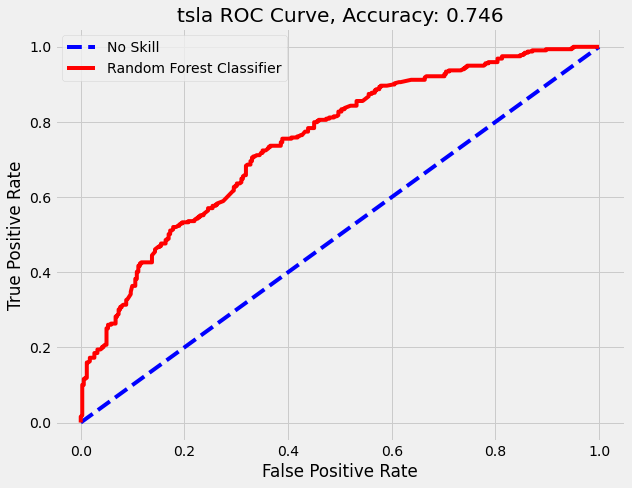

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

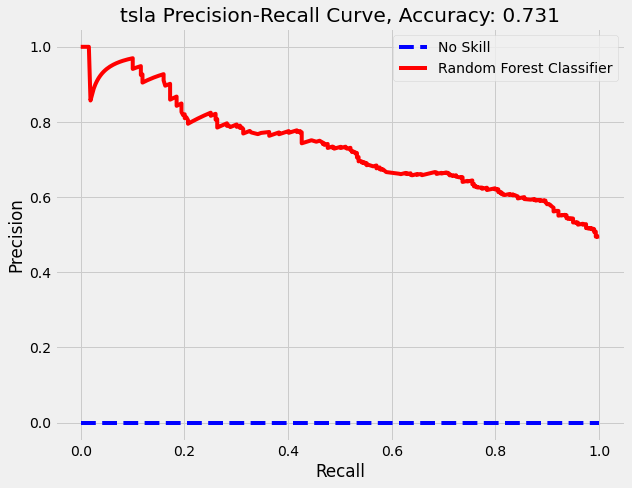

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

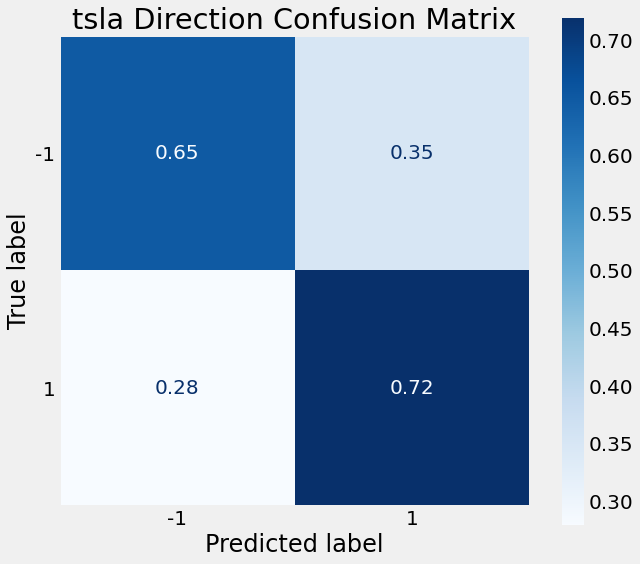

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6974587557999655'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          6.966000e+02
Low           6.683600e+02
Open          6.720000e+02
Close         6.947800e+02
Volume        4.264680e+07
Adj Close     6.947800e+02
oc           -3.389885e-02
hl            4.225266e-02
adj           4.322894e-02
5stdev_adj    1.725911e-02
5sma_adj      1.656939e-02
direction    -1.000000e+00
Name: 2020-12-30 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.033899
hl            0.042253
5stdev_adj    0.017259
5sma_adj      0.016569
Name: 2020-12-30 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold tsla


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-23,651.500000,622.570007,632.200012,645.979980,33173000.0,645.979980,-0.021797,0.046469,0.008808,0.051335,0.008404,1,-1,-0.024444
2020-12-24,666.090027,641.000000,642.989990,661.770020,22865600.0,661.770020,-0.029207,0.039142,0.024444,0.046440,0.002653,-1,-1,-0.002901
2020-12-28,681.400024,660.799988,674.510010,663.690002,32278600.0,663.690002,0.016041,0.031174,0.002901,0.034420,-0.008689,1,1,0.003465
2020-12-29,669.900024,655.000000,661.000000,665.989990,22910800.0,665.989990,-0.007549,0.022748,0.003465,0.014013,0.004994,1,-1,-0.043229
2020-12-30,696.599976,668.359985,672.000000,694.780029,42646800.0,694.780029,-0.033899,0.042253,0.043229,0.017259,0.016569,-1,-1,-0.001209


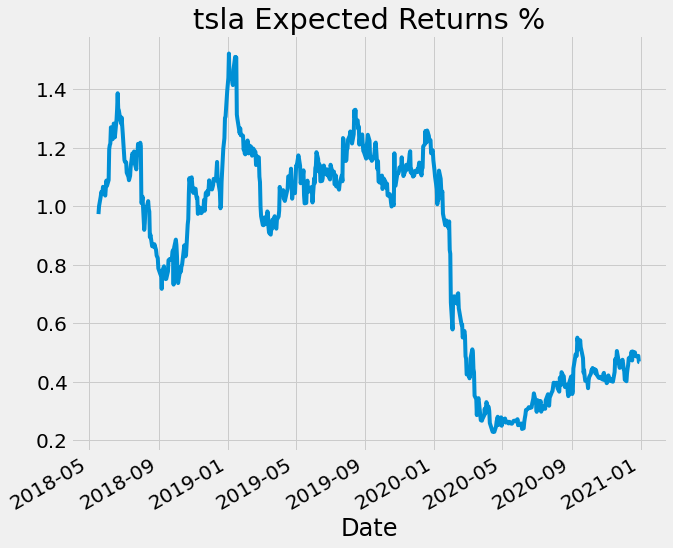

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

3.220397397270833

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

97.80261986483782

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/